<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/Chapter_6_PGGAN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6장: ProGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-6/Chapter_6_ProGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

이 코랩 / 주피터 노트북은 다음 순서로 진행됩니다:

1. 이 장에 실린 코드:

  1.1 고해상도 층으로 점진적 증대와 단계적 도입
  
  1.2 미니배치 표준편차
  
  1.3 균등 학습률
  
  1.4 픽셀별 특성 정규화
  
2. 텐서플로 허브를 사용해 모델을 다운로드하여 128x128 크기 이미지를 생성하기
3. 텐서플로 허브 팀이 제공한 코드

--- 
먼저 필요 라이브러리를 임포트하겠습니다.

## 1.1  고해상도 층으로 점진적 증대와 단계적 도입

단순히 크기를 늘리는 경로와 학습되는 업스케일 경로를 부드럽게 합치는 것부터 시작해 보죠. 이 방식이 저해상도 파라미터에서 고해상도 파라미터로 학습을 전이하기 때문에 점진적 증대에 핵심 부분입니다. 이것이 ProGAN과 라플라시안 피라미드 사이의 주요 차이점입니다.

In [1]:
import tensorflow as tf
import tensorflow.keras as K

In [2]:
def upscale_layer(layer, upscale_factor):
    '''
    upscale_factor(int)만큼 층(텐서)을 업스케일합니다.
    텐서 크기는 [group, height, width, channels]입니다.
    '''
    height, width = layer.get_shape()[1:3]
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
    '''
    임곗값 알파를 기반으로 층을 부드럽게 합칩니다.
    이 함수는 모든 층이 이미 RGB로 바뀌었다고 가정합니다.
    생성자를 위한 함수입니다.
    :list_of_layers    :   해상도(크기) 순서대로 정렬된 텐서 리스트
    :alpha             :   (0,1) 사이의 실수
    '''
    # 업스케일링을 위해 끝에서 두 번째 층을 선택합니다.
    last_fully_trained_layer = list_of_layers[-2]
    # 마지막으로 훈련된 층을 업스케일링합니다.
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

    # 새로 추가된 층은 아직 완전히 훈련되지 않았습니다.
    larger_native_layer = list_of_layers[-1]

    # 합치기 전에 층 크기가 같은지 확인합니다.
    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

    # 곱셈은 브로드캐스팅되어 수행됩니다.
    new_layer = (1-alpha) * last_layer_upscaled + larger_native_layer * alpha

    return new_layer

## 1.2 미니배치 표준편차

책에서 훨씬 자세히 설명하고 있지만 간단히 요약해 보죠. 배치에 있는 샘플의 분산이 얼마인지 판별자에게 알려주어 모드 붕괴를 피합니다.

In [3]:
def minibatch_std_layer(layer, group_size=4):
    '''
    층의 미니배치 표준편차를 계산합니다.
    층의 데이터 타입은 float32로 가정합니다. 그렇지 않으면 타입 변환이 필요합니다.
    '''
    # 미니배치는 group_size로 나눌 수 있거나 group_size 보다 같거나 작아야 합니다.
    group_size = K.backend.minimum(group_size, tf.shape(layer)[0])

    # 간단하게 쓰기 위해 크기 정보를 따로 저장합니다. 
    # 그래프 실행 전에는 일반적으로 배치 차원이 None이기 때문에 tf.shape에서 이 크기를 얻습니다.
    shape = list(K.int_shape(input))
    shape[0] = tf.shape(input)[0]

    # 미니배치 수준에서 연산하기 위해 크기를 바꿉니다. 
    # 이 코드는 층이 [그룹(G), 미니배치(M), 너비(W), 높이(H), 채널(C)]라고 가정합니다. 
    # 하지만 씨아노(Theano) 방식의 순서를 사용하는 구현도 있습니다.
    minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))

    # [M, W, H, C] 그룹의 평균을 계산합니다.
    minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
    # [M, W, H, C] 그룹의 분산을 계산합니다.
    minibatch = tf.reduce_mean(K.backend.square(minibatch), axis = 0)
    # [M,W,H,C] 그룹의 표준편차를 계산합니다.
    minibatch = K.backend.square(minibatch + 1e-8)
    # 특성 맵을 평균하여 [M,1,1,1] 픽셀을 얻습니다.
    minibatch = tf.reduce_mean(minibatch, axis=[1,2,3], keepdims=True)
    # 스칼라 값을 그룹과 픽셀에 맞게 변환합니다.
    minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]])
    # 새로운 특성 맵을 추가합니다.
    return K.backend.concatenate([layer, minibatch], axis=1)

## 1.3 균등 학습률

이 부분이 논문의 흑마법 중 하나입니다. 여기서는 간단히 발견된 문제를 고치려는 경험적인 기법이라고 생각하겠습니다.

In [4]:
def equalize_learning_rate(shape, gain, fan_in=None):
    '''
    He 초기화의 상수로 모든 층의 가중치를 조정하여 
    특성마다 각기 다른 다이나믹 레인지를 가지도록 분산을 맞춥니다.
    shape   :   텐서(층)의 크기: 각 층의 차원입니다.
        예를 들어, [4,4,48,3]. 이 경우 [커널크기, 커널크기, 필터개수, 특성맵]입니다. 
        하지만 구현에 따라 조금 다를 수 있습니다.
    gain    :   일반적으로 sqrt(2)
    fan_in  :   세이비어/He 초기화에서 입력 연결 개수
    '''
    # 기본값은 특성 맵 차원을 제외하고 shape의 모든 차원을 곱합니다. 이를 통해 뉴런마다 입력 연결 개수를 얻습니다.
    if fan_in is None: fan_in = np.prod(shape[:-1])
    # He 초기화 상수 (He et al, 2015)
    std = gain / K.sqrt(fan_in)
    # 조정을 위한 상수를 만듭니다.
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    # 가중치 값을 얻어 브로드캐스팅으로 wscale을 적용합니다.
    adjusted_weights = K.get_value('layer', shape=shape, 
            initializer=tf.initializers.random_normal()) * wscale
    return adjusted_weights

## 1.4 픽셀별 특성 정규화

이것도 책에서 자세히 설명합니다. 하지만 아래에서 볼 수 있듯이 매우 간단한 코드입니다:

In [5]:
def pixelwise_feat_norm(inputs, **kwargs):
    '''
    Krizhevsky 등이 2012년 논문에 제안한 픽셀별 특성 정규화
    :inputs : 케라스 / TF 층
    '''
    normalization_constant = K.backend.sqrt(K.backend.mean(
                    inputs**2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

# 2 ProGAN 실행하기

훈련없이 몇 줄의 코드만으로 128x128 크기 얼굴 샘플을 생성할 수 있습니다!

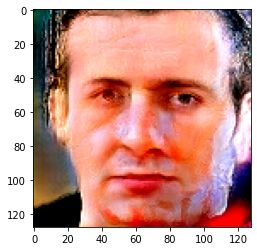

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# TFHub에서 ProGAN을 임포트합니다.
module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")
# 생성할 샘플의 잠재 공간 차원
latent_dim = 512

# 시드를 바꾸면 다른 얼굴을 생성합니다.
latent_vector = tf.random.normal([1, latent_dim], seed=1337)

# 모듈을 사용해 잠재 공간에서 이미지를 생성합니다.
interpolated_images = module(latent_vector)

plt.imshow(interpolated_images.numpy().reshape(128,128,3))
plt.show()

## 3. ProGAN 확장하기

책에는 없는 예제이지만 다양한 용도로 활용할 수 있다는 가능성을 보여주고 조금 더 고급 애플리케이션에 대한 아이디어를 주기 위해 포함했습니다.

다음 코드는 텐서플로 허브 팀이 작성했습니다.

##### Copyright 2018 The TensorFlow Hub Authors.


Licensed under the Apache License, Version 2.0 (the "License");

In [7]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub 이미지 생성 모델

노트: 이 노트북을 아무 설정없이 [코랩](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb)에서 실행할 수 있습니다.

이 노트북은 GAN을 기반으로 하는 TF-Hub 모듈을 사용하는 방법을 보여줍니다.
이 모듈은 N-차원 벡터의 잠재 공간을 RGB 이미지로 매핑합니다.

두 개의 예제를 제공합니다:
* 잠재 공간을 이미지로 **매핑** 하기
* **경사 하강법을 사용해** 타깃 이미지와 비슷한 이미지를 생성하는 잠재 공간의 벡터를 찾기

In [8]:
from absl import logging
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

# 어떤 모델을 사용할지 사전에 모른다면
# module.get_input_shapes()로 이 값을 얻을 수 있습니다.
latent_dim = 512


# 0이 아니고 원점을 통과하는 직선에 놓여 있지 않는 두 벡터 사이를 보간합니다.
# 먼저 v2를 정규화하여 v1과 같은 노름을 가지도록 만듭니다.
# 그다음 초구(hypersphere)에 있는 두 벡터 사이를 보간합니다.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)


# 일련의 이미지에서 애니메이션을 만듭니다.
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    with open('./animation.gif','rb') as f:
        display.display(display.Image(data=f.read(), height=300))


# 간단히 이미지를 출력합니다.
def display_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)


# 여러 개의 이미지를 하나의 그림으로 출력합니다.
def display_images(images, captions=None):
    num_horizontally = 5
    f, axes = plt.subplots(
        len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
    for i in range(len(images)):
        axes[i // num_horizontally, i % num_horizontally].axis("off")
        if captions is not None:
            axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
        axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
    f.tight_layout()

logging.set_verbosity(logging.ERROR)

## 잠재 공간 보간

### 랜덤 벡터

두 개의 랜덤한 초기 벡터 사이의 잠재 공간 보간. 사전 훈련된 ProGAN 모델을 담고 있는 TF-Hub 모듈 [progan-128](https://tfhub.dev/google/progan-128/1)을 사용하겠습니다.

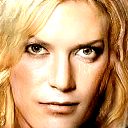

In [9]:
def interpolate_between_vectors():
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")

    # 다른 랜덤 벡터를 사용하려면 시드 값을 변경하세요.
    v1 = tf.random.normal([latent_dim], seed=3)
    v2 = tf.random.normal([latent_dim], seed=1)

    # v1과 v2 사이 25개의 스텝을 담은 보간 텐서를 만듭니다.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # 모듈을 사용해 잠재 공간에서 이미지를 생성합니다.
    interpolated_images = module(vectors)

    animate(interpolated_images)

interpolate_between_vectors()

### 다양한 실험해보기

이미지가 모듈의 공간에 있다면 경사 하강법은 괜찮은 샘플로 빠르게 수렴합니다.
**모듈 공간에 없는** 이미지로 실험해 보세요.
이미지가 훈련 이미지와 비슷할 때만 수렴할 것입니다.

어떻게 빠르게 수렴하고 더 실제와 같은 이미지를 만들 수 있을까요? 다음을 시도해 보세요:
* 이미지 차이를 계산하는데 다른 손실을 사용하기. 예를 들면 거리의 제곱.
* 잠재 벡터에 다른 규제를 적용하기
* 랜덤 벡터로 여러 번 실행하여 초기화하기

## 잠재 공간에서 가장 가까운 벡터 찾기

타깃 이미지를 고정하기 위해 모듈이 생성한 이미지나 자신의 이미지를 업로드하여 사용합니다.

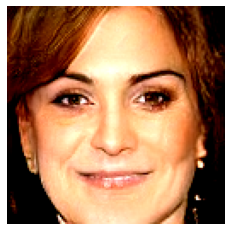

In [10]:
image_from_module_space = True

def get_module_space_image():
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")
    vector = tf.random.normal([1, latent_dim], seed=4)
    images = module(vector)
    return images[0]

def upload_image():
    uploaded = files.upload()
    image = imageio.imread(uploaded[uploaded.keys()[0]])
    return transform.resize(image, [128, 128])

if image_from_module_space:
    target_image = get_module_space_image()
else:
    target_image = upload_image()
display_image(target_image)

타깃 이미지와 잠재 공간으로 생성한 이미지 사이의 손실 함수를 정의합니다. 
그다음 경사 하강법을 사용해 이 손실을 최소화하는 변수 값을 찾습니다.

In [11]:
def find_closest_latent_vector(num_optimization_steps, steps_per_image):
    images = []
    losses = []
    module = hub.KerasLayer("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random.normal([1, latent_dim], seed=5)
    
    vector = tf.Variable(initial_vector)  
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

    for step in range(num_optimization_steps):
        if (step % 100)==0:
            print()
        print('.', end='')
        with tf.GradientTape() as tape:
            image = module(vector.read_value())
            if (step % steps_per_image) == 0:
                images.append(image.numpy().reshape(128,128,3))
            target_image_difference = loss_fn(image, target_image[:,:,:3])
            # 잠재 벡터는 정규 분포에서 샘플링했습니다.
            # 잠재 벡터의 길이를 이 분포에서 얻은 벡터의 평균 길이로 제한하면 
            # 더 실제 같은 이미지를 얻을 수 있습니다.
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

            loss = target_image_difference + regularizer
            losses.append(loss.numpy())
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))
    
    return images, losses

result = find_closest_latent_vector(num_optimization_steps=200, steps_per_image=5)


....................................................................................................
....................................................................................................

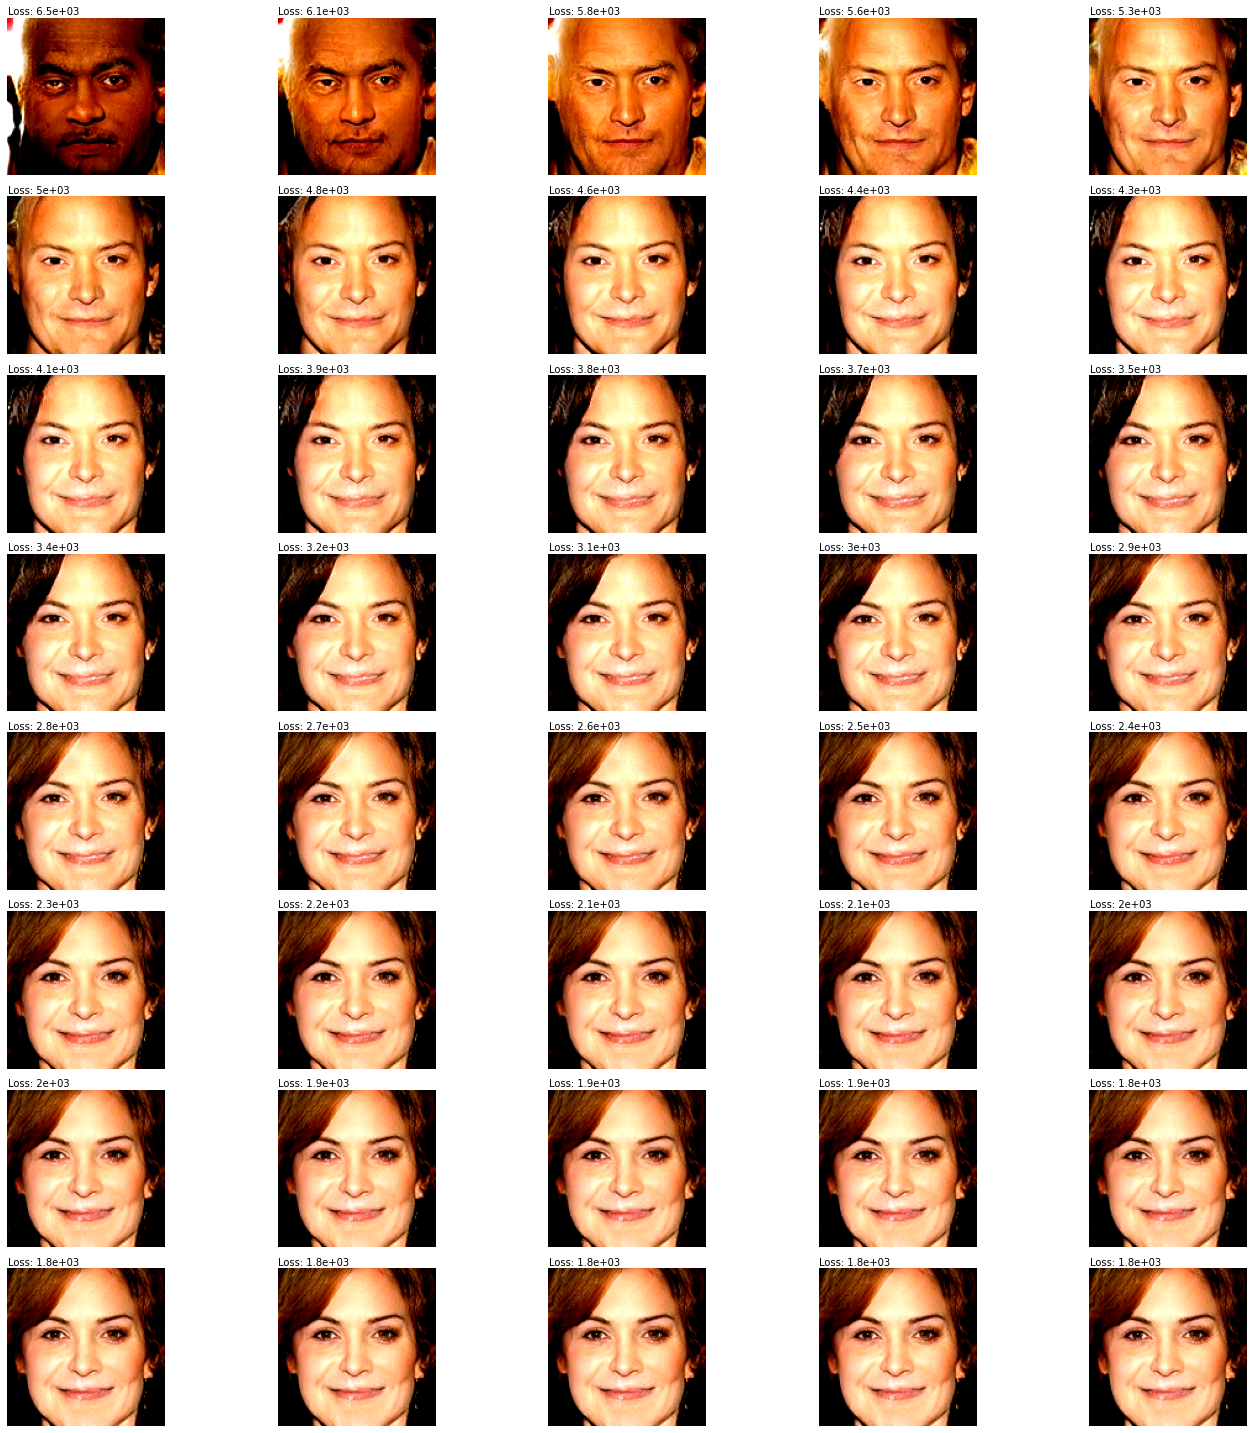

In [12]:
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)